# Popular Data Science Questions

The task in this project is to figure out what is best content to write about in Data Science based on interest by subject. The information and data used will be harvested from [Data Science Stack Exchange](https://datascience.stackexchange.com/), which is a website dedicated to Data Science questions, answers, and posts in general. 

**What kind of questions are welcome on this site?**
Questions related to Data Science, that are objective and relative to others. Questions that are subjective and theoretical should be avoided. 

**What, other than questions, does the site's home subdivide into?**
The Home is also subdivided into Questions, Tags, Users, and Unanswered.

- Questions - the questions that were asked.
- Tags - tags that can be used to categorize questions.
- Users - users from this website
- Unanswered - questions that have not been answered yet. 

The tags will probably we very useful in finding the most talked about subjects, especially in a website that is moderated by the data science community.

**What information is available in each post?**
- The title
- when it was posted
- when it was last active
- how many times it was viewed
- the description/body
- tags used
- when it was edited
- who it was posted by
- number of upvotes
- comments and number of comments. 

## Getting the Data
Stack Exchange provides a public data base for each of its websites. [Here's](https://data.stackexchange.com/datascience/query/new) a link to query and explore Data Science Stack Exchange's database.

After running a few queries and analysing the data model, it seems like the tables *Posts*, *Tags*, *TagSynonyms*, and *PostTags* seem promising. 

The following query will bring us information on the question posts from 2019. The information we need is post ID, type, creation date, score, view count, tags, answer count and favorite count. 

`SELECT Id, PostTypeID, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount FROM posts
WHERE CreationDate > '2019-01-01' AND PostTypeID = '1'`

From the database we can export and csv file and import it into a dataframe here for futher analysis. 

In [60]:
import pandas as pd 
import numpy as np

questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

## Exploring the Data

By using head and info we're able to see the first few rows of the dataframe and also information about the data type of each column and the non-null count. This will help us see if there is any cleaning we need to do.

In [61]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,54441,2019-06-25 08:44:45,1,40,<python><deep-learning><convnet><image-recogni...,1,NaN
1,54443,2019-06-25 09:30:07,1,1285,<python><deep-learning><keras><tensorflow>,1,NaN
2,54450,2019-06-25 11:44:43,4,722,<dataset><data><training><evaluation><object-d...,1,2.0
3,54452,2019-06-25 11:51:11,-1,81,<r><programming>,2,1.0
4,54453,2019-06-25 12:12:45,2,114,<regression><cross-validation>,1,1.0


In [62]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7081 entries, 0 to 7080
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7081 non-null   int64         
 1   CreationDate   7081 non-null   datetime64[ns]
 2   Score          7081 non-null   int64         
 3   ViewCount      7081 non-null   int64         
 4   Tags           7081 non-null   object        
 5   AnswerCount    7081 non-null   int64         
 6   FavoriteCount  1549 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 387.4+ KB


In [63]:
questions["Tags"].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

From using `head` and `info`  we're able to see the first few rows of the dataframe and also information about the data type of each column and the non-null count. 

There doesn't seem to be null values except for in the `FavoriteCount` column, and it also has the datatype `float64` which we need to change to `int64`. It also seems like we'll have to work on the `Tags` column, given each tag is separated by `< >`.

## Cleaning the Data

In the following steps we will:

- fill in the null values with 0
- transform `FavoriteCount` from `float64` to `int64`
- transform `CreationDate` from `object` to `datetime64`
- adjust `Tags` to remove the `<` and `>`  

In [64]:
questions = questions.fillna(0)

questions['FavoriteCount'] = questions['FavoriteCount'].astype('int64')

questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")

questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,54441,2019-06-25 08:44:45,1,40,"[python, deep-learning, convnet, image-recogni...",1,0
1,54443,2019-06-25 09:30:07,1,1285,"[python, deep-learning, keras, tensorflow]",1,0
2,54450,2019-06-25 11:44:43,4,722,"[dataset, data, training, evaluation, object-d...",1,2
3,54452,2019-06-25 11:51:11,-1,81,"[r, programming]",2,1
4,54453,2019-06-25 12:12:45,2,114,"[regression, cross-validation]",1,1


In [65]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7081 entries, 0 to 7080
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7081 non-null   int64         
 1   CreationDate   7081 non-null   datetime64[ns]
 2   Score          7081 non-null   int64         
 3   ViewCount      7081 non-null   int64         
 4   Tags           7081 non-null   object        
 5   AnswerCount    7081 non-null   int64         
 6   FavoriteCount  7081 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 387.4+ KB


## Finding most popular tags

Having done those adjustments, now we can focus on determining the most popular tags. We'll do that by counting how many times each tag was used, counting how many times a question with that tag was viewed, and finally we will create visualizations for the top tags of each of the above results.

In [66]:
# Counting how many times each tag was used

count_tags = dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in count_tags:
            count_tags[tag] += 1 
        else: 
            count_tags[tag] = 1 


In the code above, we created a dictionary that counted how many times each tag was used. To make it easier to manipulate and view, we'll transform the dictionary into a dataframe.

In [67]:
count_tags = pd.DataFrame.from_dict(count_tags, orient = "index")
count_tags.rename(columns={0: "Count"}, inplace=True)
count_tags.head()

,Count
python,1496
deep-learning,935
convnet,87
image-recognition,64
keras,749


In [68]:
count_tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, python to google-prediction-api
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   496 non-null    int64
dtypes: int64(1)
memory usage: 7.8+ KB


As you can see above, it is not ordered from greatest to least and there are 496 different entries. The next thing we'll do is order from the most used to least used and extract only the top 20.

In [69]:
most_used = count_tags.sort_values('Count', ascending = False).head(20)
most_used

,Count
machine-learning,2206
python,1496
deep-learning,935
neural-network,857
keras,749
classification,591
scikit-learn,456
tensorflow,439
nlp,410
cnn,395


The next step is counting how many times a question with that tag was viewed. To do that, we'll run through the questions and add the "ViewCount" for every question that has that tag. 

In [70]:
view_count = dict()
for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in view_count:
            view_count[tag] += row['ViewCount']
        else: 
            view_count[tag] = row['ViewCount']
            
view_count

{'python': 1553679,
 'deep-learning': 577067,
 'convnet': 39414,
 'image-recognition': 18332,
 'keras': 682248,
 'tensorflow': 333220,
 'dataset': 106055,
 'data': 51645,
 'training': 50047,
 'evaluation': 20815,
 'object-detection': 30096,
 'r': 87768,
 'programming': 2646,
 'regression': 120405,
 'cross-validation': 53720,
 'text-mining': 25982,
 'information-retrieval': 5758,
 'topic-model': 6350,
 'clustering': 87057,
 'linear-regression': 53572,
 'nlp': 202021,
 'word2vec': 45477,
 'pandas': 709515,
 'data-cleaning': 78185,
 'neural-network': 489330,
 'multiclass-classification': 51095,
 'dimensionality-reduction': 15789,
 'regularization': 15421,
 'cnn': 199820,
 'hyperparameter': 8456,
 'hyperparameter-tuning': 19739,
 'machine-learning': 1003454,
 'time-series': 167197,
 'variance': 11748,
 'bias': 8787,
 'scikit-learn': 367374,
 'data-science-model': 60450,
 'deep-network': 8557,
 'implementation': 9601,
 'image-classification': 87789,
 'computer-vision': 79072,
 'svm': 32465,

Similar to the "most used" situation, we'll also transform the dictionary into a dataframe and order from greatest to least.

In [71]:
view_count = pd.DataFrame.from_dict(view_count, orient = "index")
view_count.rename(columns={0: "Count"}, inplace=True)
most_viewed = view_count.sort_values('Count', ascending = False).head(20)
most_viewed

,Count
python,1553679
machine-learning,1003454
pandas,709515
keras,682248
deep-learning,577067
neural-network,489330
scikit-learn,367374
tensorflow,333220
classification,277457
dataframe,270076


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002781E5068C8>],
      dtype=object)

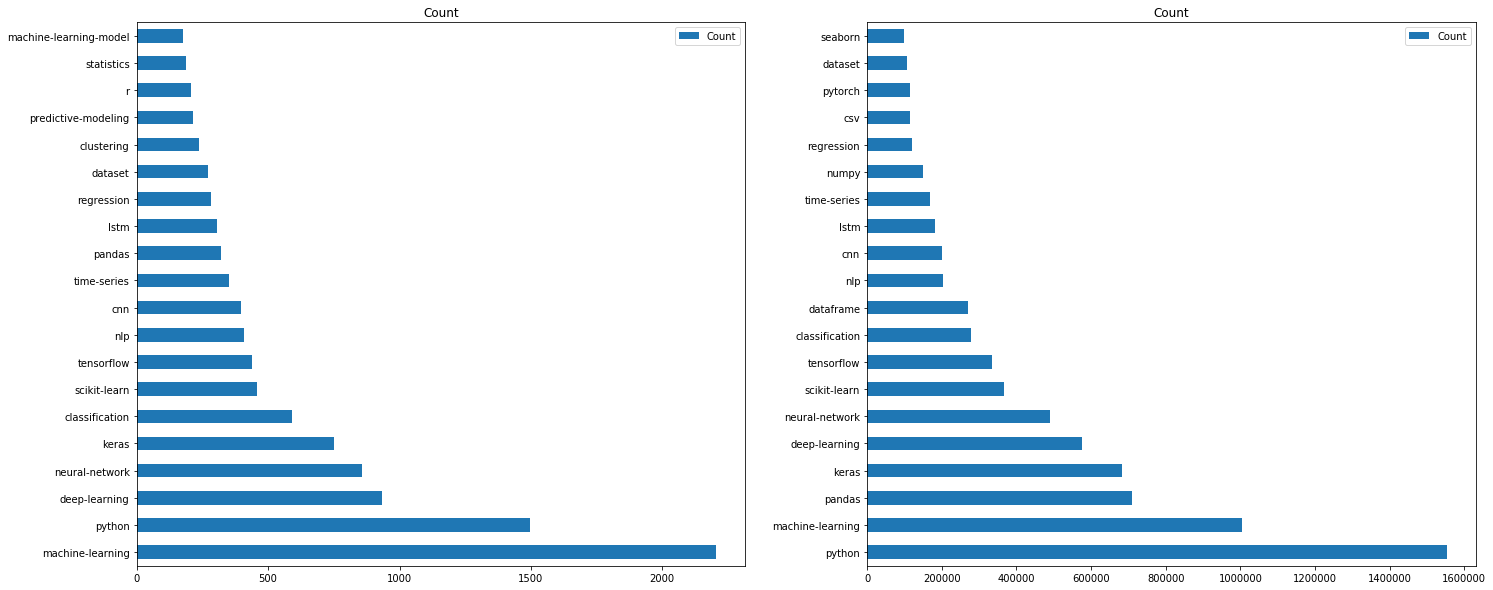

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)


# Analyzing relations between most popular tags

Let's try to analyze the relationship between the most used tags and the most viewed tags. First we will do that by comparing the used and viewed counts of the tags.  

In [73]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True, suffixes=('_used', '_viewed'))
in_used

,Count_used,Count_viewed
machine-learning,2206,1003454.0
python,1496,1553679.0
deep-learning,935,577067.0
neural-network,857,489330.0
keras,749,682248.0
classification,591,277457.0
scikit-learn,456,367374.0
tensorflow,439,333220.0
nlp,410,202021.0
cnn,395,199820.0


In [74]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True, suffixes=('_used', '_viewed'))
in_viewed

,Count_used,Count_viewed
python,1496.0,1553679
machine-learning,2206.0,1003454
pandas,322.0,709515
keras,749.0,682248
deep-learning,935.0,577067
neural-network,857.0,489330
scikit-learn,456.0,367374
tensorflow,439.0,333220
classification,591.0,277457
dataframe,NaN,270076


Next let's compare how many times each pair appears together. To do this, we'll first create a list of all the tags, and then create a dataframe and fill it with the tag relationship. 

In [75]:
all_tags = list(count_tags.index)
all_tags

['python',
 'deep-learning',
 'convnet',
 'image-recognition',
 'keras',
 'tensorflow',
 'dataset',
 'data',
 'training',
 'evaluation',
 'object-detection',
 'r',
 'programming',
 'regression',
 'cross-validation',
 'text-mining',
 'information-retrieval',
 'topic-model',
 'clustering',
 'linear-regression',
 'nlp',
 'word2vec',
 'pandas',
 'data-cleaning',
 'neural-network',
 'multiclass-classification',
 'dimensionality-reduction',
 'regularization',
 'cnn',
 'hyperparameter',
 'hyperparameter-tuning',
 'machine-learning',
 'time-series',
 'variance',
 'bias',
 'scikit-learn',
 'data-science-model',
 'deep-network',
 'implementation',
 'image-classification',
 'computer-vision',
 'svm',
 'seaborn',
 'bayesian',
 'monte-carlo',
 'classification',
 'model-selection',
 'classifier',
 'dataframe',
 'bioinformatics',
 'word-embeddings',
 'text',
 'ipython',
 'image',
 'project-planning',
 'convolution',
 'backpropagation',
 'dropout',
 'transfer-learning',
 'faster-rcnn',
 'vgg16',
 'lst

In [76]:
associations = pd.DataFrame(index = all_tags, columns = all_tags)
associations.head()

,python,deep-learning,convnet,image-recognition,keras,tensorflow,dataset,data,training,evaluation,...,lda-classifier,knime,stata,text-filter,dirichlet,doc2vec,rmse,anova,community,google-prediction-api
python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deep-learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
convnet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image-recognition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
keras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will now fill this dataframe with zeroes and then, for each lists of tags in questions["Tags"], we will increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, it tells us how many times they were used together.

In [77]:
associations.fillna(value = 0, inplace = True)
associations.head()

,python,deep-learning,convnet,image-recognition,keras,tensorflow,dataset,data,training,evaluation,...,lda-classifier,knime,stata,text-filter,dirichlet,doc2vec,rmse,anova,community,google-prediction-api
python,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
deep-learning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
convnet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
image-recognition,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
keras,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1
    
associations.head(10)   

,python,deep-learning,convnet,image-recognition,keras,tensorflow,dataset,data,training,evaluation,...,lda-classifier,knime,stata,text-filter,dirichlet,doc2vec,rmse,anova,community,google-prediction-api
python,1496,112,15,6,215,124,45,35,8,6,...,1,0,0,0,0,0,0,0,1,0
deep-learning,112,935,36,13,204,107,21,1,19,3,...,0,0,0,0,0,0,0,0,0,0
convnet,15,36,87,2,31,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
image-recognition,6,13,2,64,6,3,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
keras,215,204,31,6,749,209,9,0,10,6,...,0,0,0,0,0,0,0,0,0,1
tensorflow,124,107,9,3,209,439,8,0,8,0,...,0,0,0,0,0,0,0,0,0,1
dataset,45,21,0,3,9,8,270,33,14,1,...,0,0,0,0,0,0,0,0,0,0
data,35,1,0,0,0,0,33,176,4,1,...,0,0,1,0,0,0,0,0,0,0
training,8,19,0,2,10,8,14,4,113,1,...,0,0,0,0,0,0,0,0,0,0
evaluation,6,3,0,0,6,0,1,1,1,54,...,0,0,0,0,0,0,0,0,0,0


Since the result is a huge dataframe, let's filter it down just to the most used tags. 

In [79]:
relations_most_used = associations.loc[most_used.index, most_used.index]
relations_most_used

,machine-learning,python,deep-learning,neural-network,keras,classification,scikit-learn,tensorflow,nlp,cnn,time-series,pandas,lstm,regression,dataset,clustering,predictive-modeling,r,statistics,machine-learning-model
machine-learning,2206,423,337,305,158,229,164,76,96,98,108,57,45,103,82,54,101,49,77,108
python,423,1496,112,112,215,86,199,124,66,46,79,223,44,52,45,41,30,20,28,30
deep-learning,337,112,935,256,204,52,12,107,58,127,30,1,73,19,21,2,23,4,11,11
neural-network,305,112,256,857,203,53,20,83,21,99,27,1,53,41,17,4,8,6,8,8
keras,158,215,204,203,749,50,26,209,20,97,36,2,102,27,9,0,10,9,1,13
classification,229,86,52,53,50,591,41,18,32,15,19,3,13,29,22,11,24,8,15,21
scikit-learn,164,199,12,20,26,41,456,8,11,0,8,31,1,34,6,22,12,1,3,15
tensorflow,76,124,107,83,209,18,8,439,9,44,7,2,28,6,8,0,4,1,0,7
nlp,96,66,58,21,20,32,11,9,410,7,0,3,16,2,10,9,0,2,3,4
cnn,98,46,127,99,97,15,0,44,7,395,7,1,19,4,8,0,5,2,1,3


Even with a smaller dataframe, it is difficult to analyze. Therefor, let's make a heatmap to identify more easily relationship between the tags. Before that, we must remove the relationship of the tag with itself so the heatmap isn't skewed. 

In [80]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN



C:\Users\catha\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


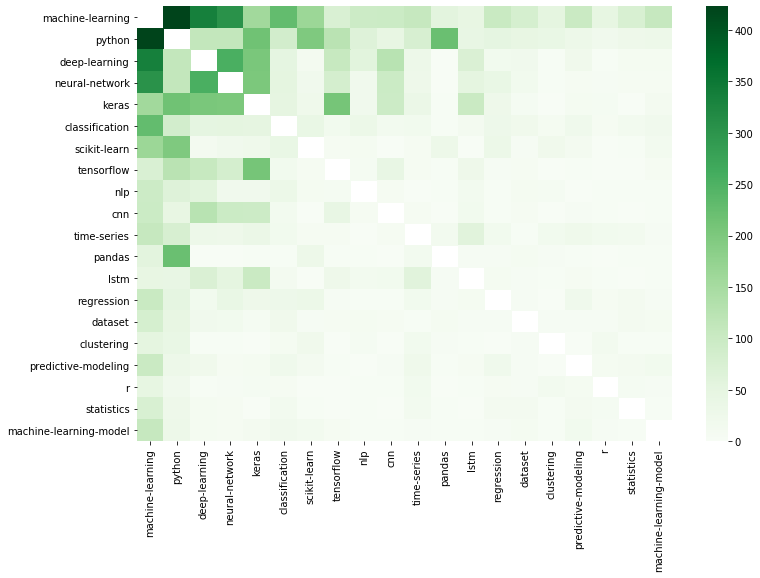

In [81]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the top left corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

In summary, this step didn't help us as much as we thought it would. 

We can still see that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: `python`, `machine-learning`, `deep-learning`, `neural-network`, `keras`, `tensorflow`, `classification`, `scikit-learn`. Most of these tags have a very familiar relationship with deep-learning (a type of neural network). From this we can determine that the most popular topic at the moment is deep learning.  

# Is Deep Learning just a fad?

To determine if deep learning is just a fad or not, we can analyze it's popularity throughout time. We'll to that by analyzing all the questions asked on DSSE and: 

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

To do that, we'll import the csv and clean the dataframe by fixing the `Tags` column as we previously did. 

In [105]:
all_q = pd.read_csv("all_q.csv", parse_dates=["CreationDate"])
all_q.head()

,Id,CreationDate,Tags
0,54441,2019-06-25 08:44:45,<python><deep-learning><convnet><image-recogni...
1,54443,2019-06-25 09:30:07,<python><deep-learning><keras><tensorflow>
2,54450,2019-06-25 11:44:43,<dataset><data><training><evaluation><object-d...
3,54452,2019-06-25 11:51:11,<r><programming>
4,54453,2019-06-25 12:12:45,<regression><cross-validation>


In [106]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

all_q.head()

,Id,CreationDate,Tags
0,54441,2019-06-25 08:44:45,"[python, deep-learning, convnet, image-recogni..."
1,54443,2019-06-25 09:30:07,"[python, deep-learning, keras, tensorflow]"
2,54450,2019-06-25 11:44:43,"[dataset, data, training, evaluation, object-d..."
3,54452,2019-06-25 11:51:11,"[r, programming]"
4,54453,2019-06-25 12:12:45,"[regression, cross-validation]"


We can classify the question as related to deep learning if it has any of the following tags: `lstm`, `cnn`, `scikit-learn`, `tensorflow`, `keras`, `neural-network`, `deep-learning`.

We will run through each row and identify if any of the tags are present. If any tag is present, we will classify it as true. 

In [107]:
def classify_dl(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1 
    return 0

In [108]:
all_q['DeepLearning'] = all_q['Tags'].apply(classify_dl)

all_q.head()

,Id,CreationDate,Tags,DeepLearning
0,54441,2019-06-25 08:44:45,"[python, deep-learning, convnet, image-recogni...",1
1,54443,2019-06-25 09:30:07,"[python, deep-learning, keras, tensorflow]",1
2,54450,2019-06-25 11:44:43,"[dataset, data, training, evaluation, object-d...",0
3,54452,2019-06-25 11:51:11,"[r, programming]",0
4,54453,2019-06-25 12:12:45,"[regression, cross-validation]",0


Now that we have determined which questions are related to Deep learning, let's analyze them through time. First let's find the oldest and most recent question creation dates. 

In [123]:
min_c = min(all_q['CreationDate'])
max_c = max(all_q['CreationDate'])

print(f"oldest: {min_c}\nrecent: {max_c}")

oldest: 2014-05-13 23:58:30
recent: 2020-11-08 02:39:02


We see that the data we have is from 2014 to 2020. Analyzing yearly might be to compressed while monthly would be expanded too much. Quartely seems to be an adequate time frame. 

In the next step we will determine in which quarter each question was created.  

In [124]:
import datetime as dt

all_q['Quarter'] = all_q['CreationDate'].apply(lambda row: str(row.year)[-2:] + 'Q' + str(row.quarter))

In [127]:
all_q.head(10)

,Id,CreationDate,Tags,DeepLearning,Quarter
0,54441,2019-06-25 08:44:45,"[python, deep-learning, convnet, image-recogni...",1,19Q2
1,54443,2019-06-25 09:30:07,"[python, deep-learning, keras, tensorflow]",1,19Q2
2,54450,2019-06-25 11:44:43,"[dataset, data, training, evaluation, object-d...",0,19Q2
3,54452,2019-06-25 11:51:11,"[r, programming]",0,19Q2
4,54453,2019-06-25 12:12:45,"[regression, cross-validation]",0,19Q2
5,54464,2019-06-25 13:06:41,"[text-mining, information-retrieval, topic-model]",0,19Q2
6,54465,2019-06-25 13:07:27,"[clustering, linear-regression]",0,19Q2
7,54467,2019-06-25 14:17:25,"[nlp, word2vec]",0,19Q2
8,54472,2019-06-25 15:59:35,"[python, pandas, data-cleaning]",0,19Q2
9,54473,2019-06-25 16:01:20,"[neural-network, multiclass-classification, di...",1,19Q2


In [132]:
all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})


DeepLearning      
                 sum  size
Quarter                   
14Q2               9   157
14Q3              13   188
14Q4              21   214
15Q1              18   189
15Q2              28   284
15Q3              45   310
15Q4              66   381
16Q1             110   511
16Q2             109   515
16Q3             160   581
16Q4             177   526
17Q1             242   691
17Q2             222   640
17Q3             246   711
17Q4             349   889
18Q1             554  1208
18Q2             568  1430
18Q3             670  1466
18Q4             527  1276
19Q1             702  1739
19Q2             675  1810
19Q3             677  1763
19Q4             698  1769
20Q1             769  2105
20Q2             948  2391
20Q3             704  1840
20Q4             285   701

In [133]:
quarterly = all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ('DeepLearing_Questions', "Total_Questions")

quarterly['DL_rate'] = quarterly['DeepLearing_Questions']/quarterly["Total_Questions"]

quarterly.head()

,DeepLearing_Questions,Total_Questions,DL_rate
Quarter,,,
14Q2,9,157,0.057325
14Q3,13,188,0.069149
14Q4,21,214,0.098131
15Q1,18,189,0.095238
15Q2,28,284,0.098592


Now let's plot this information so it's easier to analyze. 

We'll use a combination of bar and line plot.

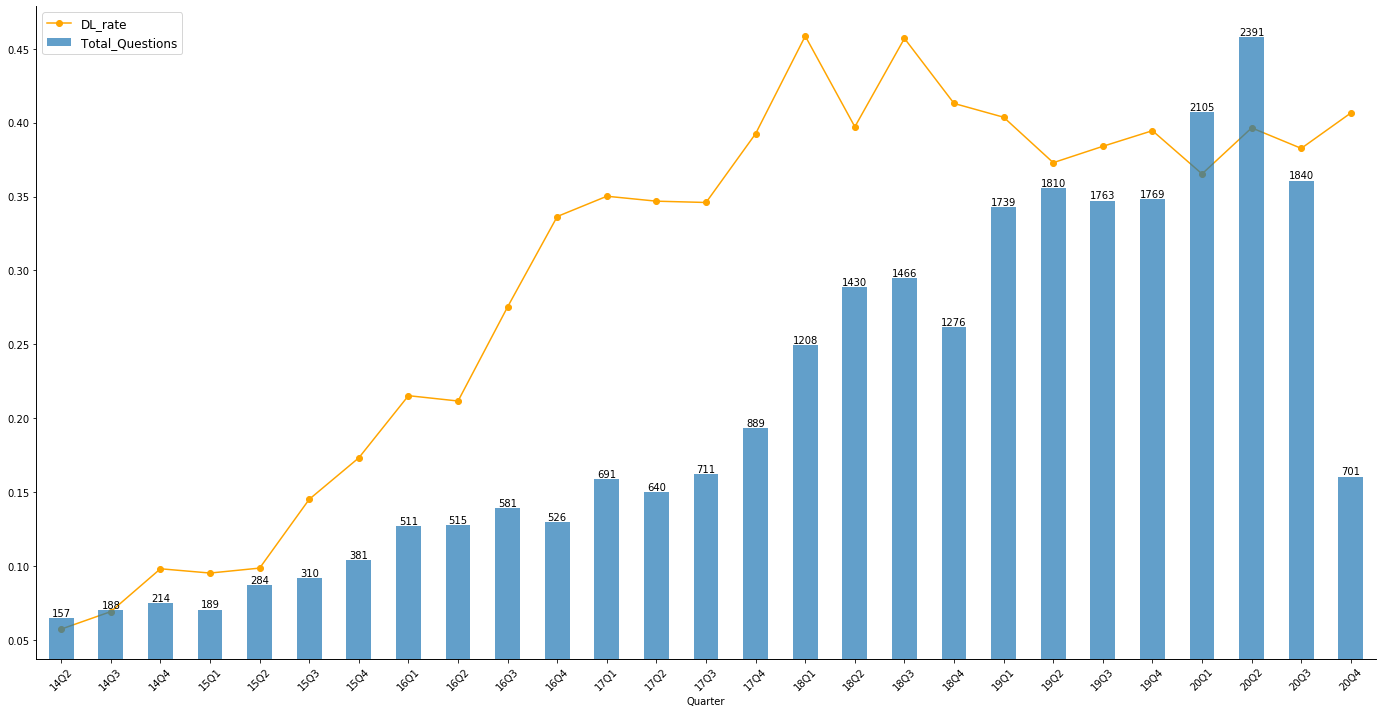

In [135]:
quarterly.reset_index(inplace=True) #since the index was the Quarter, we redefine the index to integers.

ax1 = quarterly.plot(x="Quarter", y="DL_rate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="Total_Questions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["Total_Questions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.